# Analyse von Daten über die Facebook Ad Library API

In diesem Notebook sammeln und explorieren wir Daten zu Facebook-Anzeigen von Politiker_innen über die [Facebook Ad Library API](https://www.facebook.com/ads/library/api/). Die Inhalte dieses Notebooks orientieren sich an einem sehr empfehlenswerten [Blog-Post von Roland Schmidt](https://rpubs.com/zoowalk/FB_EP2019), in dem er Daten aus der Facebook Ad Library zur Europaparlamentswahl in Österreich analysiert. Auch in vorliegenden Notebook analysieren wir Daten zur EP-Wahl 2019. Dabei fokussieren wir uns auf die beiden Politiker_innen [Katarina Barley (SPD)](https://de.wikipedia.org/wiki/Katarina_Barley) und [Nicola Beer (FDP)](https://de.wikipedia.org/wiki/Nicola_Beer), da sie die jeweiligen Spitzenkandidatinnen ihrer Parteien waren, auch aus der Bundespolitik bekannt sind und zudem in den sozialen Medien (Facebook & Twitter) recht aktiv sind.

## Vorbereitung

Bevor wir mir der Sammlung und Analyse der Daten beginnen können, müssen wir zunächst die benötigten `R`-Pakete laden. Zudem verändern wir für die Erstellung der Graphiken das Zahlenformat (Nutzung der Scientific Notation erst ab zehnstelligen Zahlen).

In [1]:
library(tidyverse)
library(httr)
library(lubridate)
library(scales)
library(lemon)
library(sf)
library(tmap)
library(tidytext)

options(scipen=8)

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --

v ggplot2 3.2.1     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following object is masked from 'package:base':

    date



Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'lemon'


The following object is masked from 'package:purrr':

    %||%


Linking to GEOS 3.6.1, GDAL 2.2.3, PROJ 4.9.3



## Datensammlung

Der erste Schritt ist die Sammlung der Daten über die Facebook Ad Library API. Hierfür benötigt man das über den [API Explorer](https://developers.facebook.com/tools/explorer/) generierte Access Token. Mit dem nachfolgenden Code sammelt man alle Daten zu Anzeigen aus der Ad Library, die über den den gesamten verfügbaren Zeitraum in Deutschland geschaltet wurden. Da dies sehr lange dauert, ist der Code in der nachfolgenden Zelle auskommentiert. Für den heutigen Workshop arbeiten wir mit einer Auswahl an Daten (für die beiden oben genannten Politikerinnen), die wir bereits zuvor gesammelt und aufbereitet haben. Über die Anpassung der `search_fields` kann man die Auswahl der Daten verändern. Hierzu empfiehlt es sich, einen Blick auf die Dokumentation für die [Ad Library API](https://www.facebook.com/ads/library/api/) zu den Suchparametern zu werfen.

In [10]:
# zuerst weisen wir den Link zur Facebook-API einem Objekt zu
# my_link<- "https://graph.facebook.com"
# 
# hier definieren wir die Suchfelder für die Ad Library API
# search_fields=c("ad_creation_time", "ad_delivery_start_time", "ad_delivery_stop_time",
#                 "ad_creative_body", 
#                 "page_id",
#                 "page_name",
#                 "currency",
#                 "spend",
#                 "demographic_distribution",
#                 "funding_entity",
#                 "impressions",
#                 "region_distribution") %>% 
#   stringr::str_c(., collapse=", ")
# 
# hier sammeln wir die Daten für die erste Seite der Suchanfrage
# page_one_response <- GET(my_link,
#                          path = "/ads_archive",
#                          query = list(access_token = "", # hier zuvor generierten Access Token einfügen
#                                       limit=100,
#                                       ad_active_status="ALL",
#                                       search_terms="''",
#                                       fields=search_fields,
#                                       ad_reached_countries="DE"))
# page_one_content<- content(page_one_response)
# 
# aus dem Ergebnis der Anfrage (Liste) erstellen wir nun einen Dataframe
# x <- tibble(data=page_one_content$data)
# df_imp <- x %>% 
#   unnest_wider(data) 
# 
# # Link für die nächste Ergebnisseite extrahieren
# next_link <- page_one_content$paging$`next`
# 
# für alle Ergebnisseiten wiederholen (d.h. bis es keinen Link zur Next Page mehr gibt) und Datensatz zusammenführen
# while(length(next_link)>0) {
#   
#   next_response <- GET(next_link)
#   next_content<- content(next_response)
#   
#   y <- tibble(data=next_content$data)
#   df_next <- y %>% 
#     unnest_wider(data) 
#   
#   df_imp <- bind_rows(df_imp, df_next)  
#   
#   next_link <- next_content$paging$`next`
# }

Da die Sammlung der Daten über die Ad Library API einige Zeit dauern kann, empfiehlt es sich, die Daten zu speichern (z.B. im `R`-eigenen Datenformat `.rds` oder als .csv-Datei). NB: Die Dateipfade in der nachfolgenden Code-Zelle müssen entsprechend angepasst werden. In den Beispielen werden die Dateien im Ordner `data` gespeichert, der sich im selben Verzeichnis befindet wie das Skript, in dem dieser Code ausgeführt wird. 

In [ ]:
# .rds-Datei
# saveRDS(df_imp, "./data")
# .csv-Datei
# write_csv(df_imp, "./data")

## Datenaufbereitung

Bevor wir die Daten analysieren und für die Erstellung von Plots verwenden können, müssen diese zunächst aufbereitet werden. Da wir Ihnen für diesen Workshop bereits aufbereitete Daten zu den Facebook-Werbeanzeigen, die von Katarina Barley (SPD) und Nicola Beer (FDP) im Zeitraum vom 01.05.2019 bis zum 26.05.2019 (= Tag der EP-Wahl) geschaltet wurden, zur Verfügung stellen, ist der Code in der nachfolgenden Zelle größtenteils auskommentiert.

In [2]:
# zeitlichen Rahmen für die Auswahl der Daten festlegen
date_observation_start <- lubridate::ymd("2019-05-01") # Startdatum
date_observation_end <- lubridate::ymd("2019-05-26") # Enddatum
#
# Parteifarben für Plots festlegen
colors <- c("#E30013", "#FFEE00") # SPD rot, FDP gelb
#
# Datensatz mit Daten zu den ausgewählten Politikerinnen (Name + Parteizugehörigkeit)
# candidates <- tribble(
#  ~name, ~party
#  "Katarina Barley", "SPD"
#  "Nicola Beer", "FDP"
#)
#
# Datensatz erstellen, der auf ausgewählte Politikerinnen und definierten Zeitraum beschränkt ist
# df_x <- df_imp %>% 
#  filter(page_name %in% candidates$name) %>% 
#  mutate_at(vars(contains("time")), lubridate::ymd_hms) %>% 
#  filter(ad_delivery_start_time %within% interval(date_observation_start,
#                                            date_observation_end)) %>% 
#  left_join(candidates, by=c("page_name"="name")) %>% 
#  mutate(candidate=paste0(page_name, " (", party, ")"),
#         ad_delivery_start_date = date(ad_delivery_start_time)) %>% 
#  arrange(page_name, ad_delivery_start_time) %>% 
#  group_by(page_name, ad_delivery_start_date) %>% 
#  mutate(ad_id=paste(stringr::str_remove_all(page_name, "[:space:]"), 
#                     lubridate::date(ad_creation_time),
#                     row_number(), sep="-")) %>% 
#  ungroup()

Der nachfolgende Link zu den zugeschnittenen und aufbereiteten Daten ist nur für den heutigen Workshop gültig und wird danach wieder deaktiviert.

In [ ]:
#download.file("https://gesisbox.gesis.org/index.php/s/cotb9XkkSp5TyTg/download", "data/fb_ads_barley_beer.rds")
#df_x <- readRDS("./data/fb_ads_barley_beer.rds")

In [3]:
df_x <- readRDS("./data/fb_ad_library_data_dataday2020.rds")

In [4]:
nrow(df_x)
table(df_x$candidate)

[1] 1506


Katarina Barley (SPD)     Nicola Beer (FDP) 
                 1410                    96 

Im Datensatz sind insgesamt 1506 verschiedene Werbeanzeigen enthalten: 1410 von Katarina Barley (SPD) und 96 von Nicola Beer (FDP).

## Anzahl neuer Anzeigen pro Tag

Der nachfolgende Plot stellt dar, wie viele neue Anzeigen die beiden Politikerinnen vom 01.05. bis zum 26.05.2019 auf Facebook neu geschaltet haben.

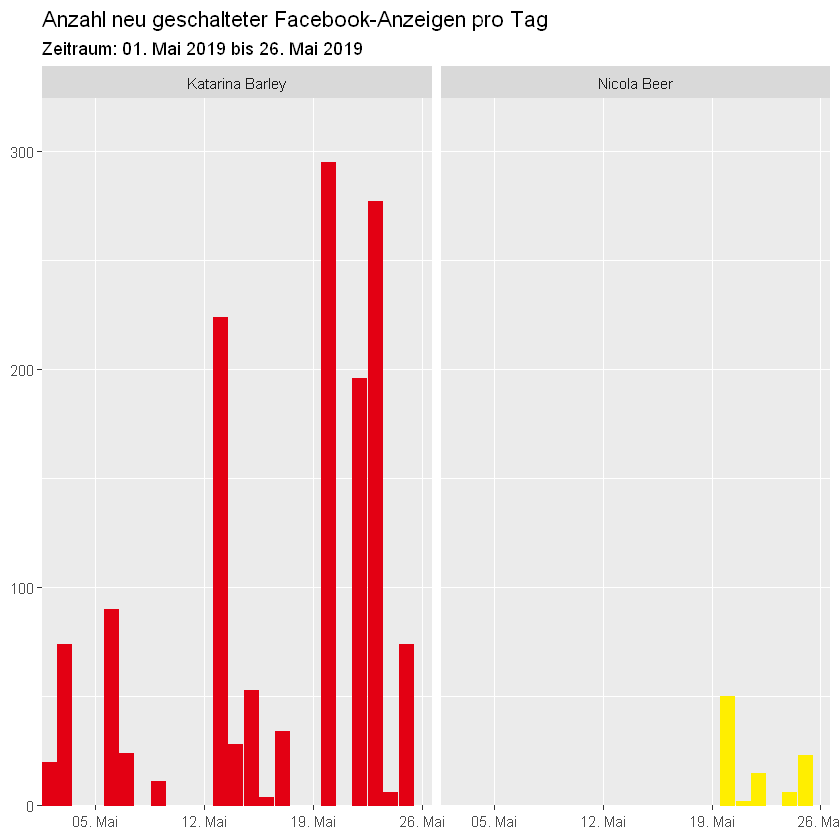

In [5]:
# Datensatz mit der Anzahl neuer Anzeigen pro Tag
ads_per_day <- df_x %>% 
  group_by(page_name, ad_delivery_start_date) %>% 
  summarize(n_ads_day = n())

# Plot
ads_per_day %>% 
  ggplot() +
  geom_bar(aes(x=ad_delivery_start_date,
               y=n_ads_day,
               fill = page_name,
               color = page_name),
           stat="identity") +
  scale_x_date(breaks=seq.Date(date_observation_end-lubridate::weeks(4), date_observation_end, by = "week"),
               labels=scales::date_format("%d. %b"),
               expand=expand_scale(mult=c(0,0.05))) +
  scale_y_continuous(expand=expand_scale(mult=c(0,0.1)))+
  labs(title="Anzahl neu geschalteter Facebook-Anzeigen pro Tag",
       subtitle=paste0("Zeitraum: ",
                       format(date(date_observation_start), "%d. %b %Y"), " bis ",
                       format(date(date_observation_end), "%d. %b %Y")))+
  scale_fill_manual(values = colors) +
  scale_color_manual(values = colors) +
  theme(axis.title=element_blank(),
        panel.grid.minor.x = element_blank(),
        legend.position = "none")+
  facet_wrap(~ page_name)

## Gesamtausgaben für Facebook-Anzeigen

Für die Kosten pro Anzeige liefert die Facebook Ad Library API keine exakten Werte. Stattdessen bekommt man kategoriale Daten (Kostenintervall mit Unter- und Obergrenze für jede Anzeige). Um mit diesen Daten arbeiten zu können, müssen sie wiederum aufbereitet werden.

In [6]:
df_x1 <- df_x %>% 
  unnest_wider(spend, names_sep = "_") %>% # nested data
  mutate_at(vars(contains("bound")), as.numeric) %>% 
  mutate(spend_mid=(spend_upper_bound-spend_lower_bound)/2+spend_lower_bound) %>% # Berechnung des Mittelpunkts der Intervalle
  mutate(spend_interval=paste0(spend_lower_bound," - ",spend_upper_bound, " €")) %>% 
  mutate(spend_interval=forcats::fct_reorder(spend_interval, spend_mid)) %>% 
  mutate(spend_interval=forcats::fct_expand(spend_interval, "5000-9999 €")) %>% 
  mutate(spend_interval=forcats::fct_relevel(spend_interval, "5000-9999 €", after=4))
# Kategorie für Kosten zwischen 5000 und 10000 Euro manuell ergänzt

# Gesamtausgaben pro Kandidatin
df_spend_total <- df_x1 %>%
  group_by(candidate) %>%
  summarise(spend_min_total=sum(spend_lower_bound, na.rm = T),
            spend_mid_total=sum(spend_mid, na.rm=T),
            spend_max_total=sum(spend_upper_bound, na.rm=T)) 

max_spend <- max(df_spend_total$spend_max_total)

Nun können wir die Gesamtausgaben für Facebook-Anzeigen im Zeitraum 01.-26.05.2019 für die beiden Politikerinnen vergleichen. Aufgrund der Art der Daten (Intervalle anstatt exakte Werte) sind Angaben zu den Gesamtausgaben mit einer gewissen Unsicherheit verbunden, die im folgenden Plot ebenfalls visualisiert werden soll.

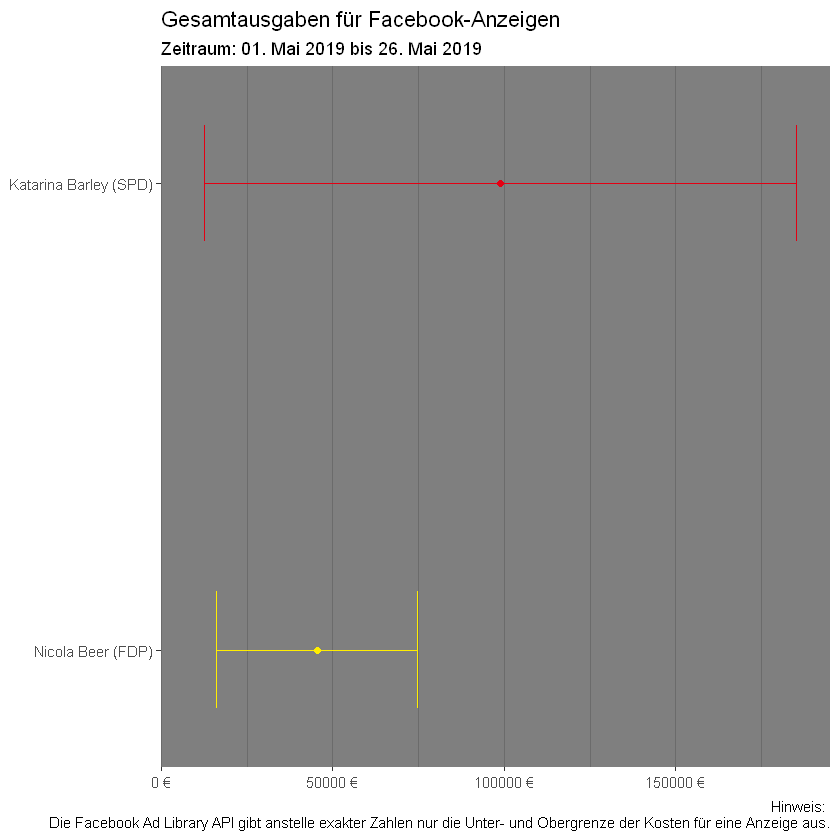

In [9]:
df_spend_total %>%   
  ggplot()+
  geom_errorbar(aes(x=reorder(candidate, spend_mid_total),
                    ymin=spend_min_total,
                    ymax=spend_max_total,
                    color=candidate,
                    width = 0.25))+
  geom_point(aes(x=reorder(candidate, spend_mid_total),
                 y=spend_mid_total,
                 color=candidate))+
  labs(title="Gesamtausgaben für Facebook-Anzeigen",
       subtitle=paste0("Zeitraum: ", 
                       format(date(date_observation_start), "%d. %b %Y"), " bis ",
                       format(date(date_observation_end), "%d. %b %Y")),
       caption = "Hinweis: \nDie Facebook Ad Library API gibt anstelle exakter Zahlen nur die Unter- und Obergrenze der Kosten für eine Anzeige aus.") +
  theme_dark()+
  theme(axis.title = element_blank(),
        panel.grid.major.y = element_blank(),
        legend.position="none")+
  scale_color_manual(values=colors)+
  scale_y_continuous(labels = function(x) paste(x, "€"), 
                     breaks=seq(0, 200000, 50000),
                     minor_breaks = seq(25000, 175000, 50000),
                     limits=c(0, max_spend + 10000),
                     expand = c(0,0)) +
  scale_x_discrete(expand=expand_scale(add=c(0.25,0.25)))+
  coord_flip()

Da die Daten zu den Kosten pro Anzeige über die Facebook Ad Library API nur in Form von Kategorien (Unter- und Obergrenzen) geliefert werden, ist eine Schätzung der Gesamtausgaben auf Grundlage dieser Daten entsprechend unpräzise. Besonders für Politikerinnen wie Katarina Barley, die viele Facebook-Anzeigen geschaltet haben, ist Spannbreite der geschätzten Gesamtkosten groß.

In [10]:
df_spend_total

candidate,spend_min_total,spend_mid_total,spend_max_total
<chr>,<dbl>,<dbl>,<dbl>
Katarina Barley (SPD),12500,98845,185190
Nicola Beer (FDP),16000,45402,74804


## Anzahl der Anzeigen pro Preiskategorie

Neben der Anzahl der geschalteten Anzeigen hängen die Gesamtkosten für Facebook-Werbung auch von den Kosten pro Anzeige ab. Politiker_innen können auf Facebook z.B. für die gleichen Gesamtkosten sehr viele günstige oder wenige teure Anzeigen schalten.

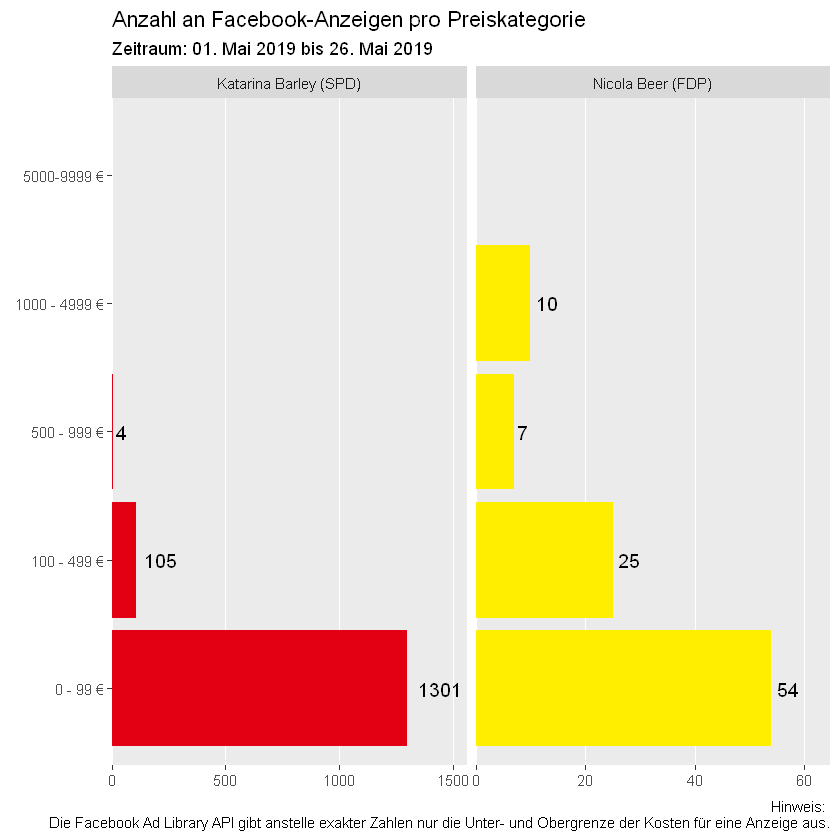

In [11]:
# Datensatz mit Anzahl der Anzeigen pro Preiskategorie für jede Person
ads_per_category <- df_x1 %>% 
  group_by(candidate, spend_interval, .drop = F) %>% 
  summarise(n_ads=n()) %>% 
  arrange(candidate)

# Plot
ads_per_category %>% 
  ggplot()+
  geom_bar(aes(x=spend_interval,
               y=n_ads,
               fill=candidate),
           color="transparent",
           stat="identity")+
  geom_text(data=. %>% filter(n_ads>0),
            aes(x=spend_interval,
                y=n_ads,
                label=n_ads),
            size = 4,
            hjust=-0.25)+
  labs(title="Anzahl an Facebook-Anzeigen pro Preiskategorie",
       subtitle=paste0("Zeitraum: ",
                       format(date(date_observation_start), "%d. %b %Y"), " bis ",
                       format(date(date_observation_end), "%d. %b %Y")),
       caption = "Hinweis: \nDie Facebook Ad Library API gibt anstelle exakter Zahlen nur die Unter- und Obergrenze der Kosten für eine Anzeige aus.",
       x="Anzahl der Anzeigen",
       y="Preiskategorie")+
  scale_y_continuous(expand=expand_scale(mult=c(0, 0.2)),
                     breaks=waiver(),
                     minor_breaks = NULL)+
  scale_fill_manual(values=colors) +
  theme(axis.title=element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.y = element_blank(),
        legend.position = "none")+
  facet_wrap(vars(candidate),
             scales = "free_x")+
  coord_flip()

Im Plot zeigt sich, dass Katarina Barley im betrachteten Zeitraum deutlich mehr Anzeigen auf Facebook geschaltet als Nicola Beer. Die teuerste Anzeige von Katarina Barley hat zwischen 500 und 999 Euro gekostet. Nicola Beer hat hingegen auch 10 Anzeigen in der Preiskategorie von 1000 bis 4999 Euro geschaltet.

## Geschlecht und Alter der erreichten Zielgruppe

Die Facebook Ad Library API liefert auch Informationen zu Geschlecht und Alter der Personen, die durch eine Anzeige erreicht wurden. Ähnlich wie bei den Kosten wird das Alter der Personen, welche die Anzeige gesehen haben, lediglich in Kategorien angegeben. Für die weiteren Auswertungen muss zunächst die Anzahl an Impressions pro Anzeige berechnet werden. [Facebook for Business](https://www.facebook.com/business/help/675615482516035) definiert Impressionen wie folgt: "Eine Impression gibt an, wie oft eine Werbeanzeigeninstanz zum ersten Mal auf einem Bildschirm angezeigt wurde. (Beispiel: Wenn eine Anzeige auf dem Bildschirm angezeigt wird und jemand nach unten und wieder hoch zu derselben Werbeanzeige scrollt, zählt das als eine Impression. Wenn eine Anzeige einer Person zu zwei verschiedenen Zeiten an einem Tag auf dem Bildschirm angezeigt wird, werden zwei Impressionen gezählt.)" 

In [12]:
impression_per_ad <- df_x1 %>% 
  ungroup() %>% 
  unnest_wider(impressions, names_sep="_") %>% 
  select(ad_id, candidate, contains("impressions")) %>% 
  mutate_at(vars("impressions_lower_bound", 
                 "impressions_upper_bound"),
            as.numeric) %>% 
  mutate(impressions_category=paste(impressions_lower_bound, "-", impressions_upper_bound)) %>%
  mutate(impressions_mid=(impressions_upper_bound-impressions_lower_bound)/2+impressions_lower_bound) %>%  
  mutate(impressions_category=as.factor(impressions_category) %>%
           forcats::fct_reorder(., impressions_mid))

Im nächsten Schritt müssen die Daten so aufbereitet werden, dass eine Berechnung des Anteils an Impressions pro Geschlecht (m/w) und Alterskategorie möglich ist.

In [16]:
df_demographics_unnested <- df_x1 %>% 
  select(ad_id, demographic_distribution, candidate) %>% 
  unnest_longer(demographic_distribution) %>% 
  unnest_wider(demographic_distribution) %>% 
  mutate(percentage=as.numeric(percentage)) %>% 
  mutate(gender=as.factor(gender),
         age=as.factor(age))  %>% 
  complete(ad_id, nesting(age, gender), fill=list(percentage=0)) %>% # Wert 0 für Kombinationen von Alter- und Geschlecht festlegen, für die es keine Daten gibt (wichtig für die Berechnung von Mittelwerten)
  group_by(ad_id) %>% 
  fill(candidate, .direction = c("downup")) %>% 
  ungroup() %>% 
  left_join(., impression_per_ad %>% select(ad_id, impressions_mid))

# gewichteten Mittelwert berechnen
df_demographics_all_ads <- df_demographics_unnested %>% 
  group_by(candidate, gender, age) %>% 
  filter(!is.na(impressions_mid)) %>% 
  summarise(mean_percentage=mean(x=percentage, 
                                 w=impressions_mid,
                                 na.rm = T)) %>% 
  mutate(mean_percentage = round(mean_percentage, 3)) %>% 
  ungroup()

Joining, by = "ad_id"



Die prozentuale Verteilung von Impressions für die Anzeigen nach Alter und Geschlecht lässt sich bspw. über eine Heatmap darstellen.

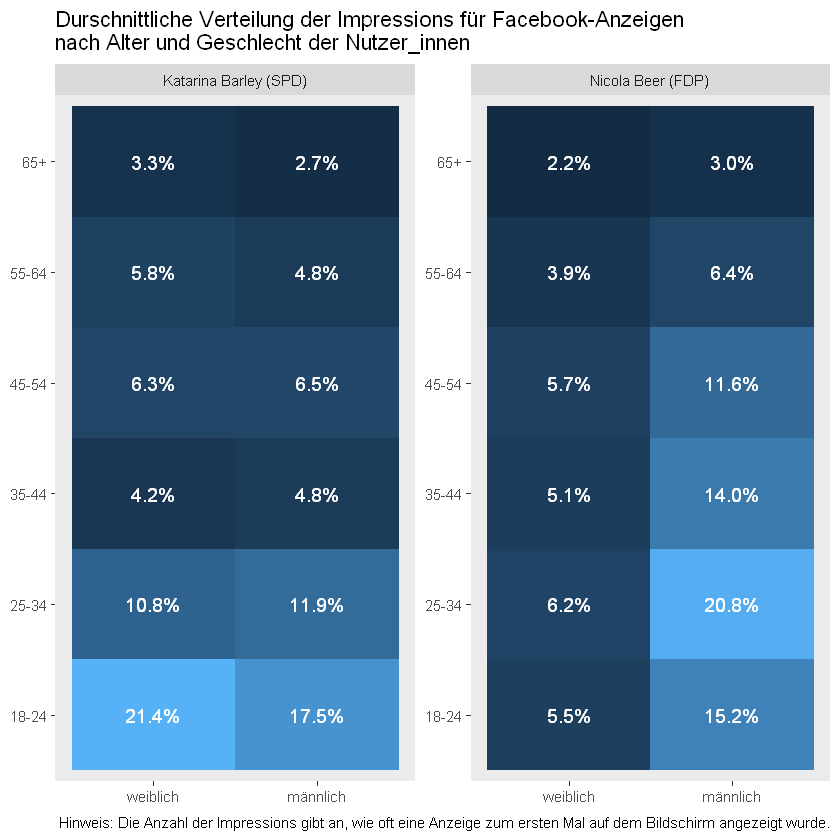

In [17]:
df_demographics_all_ads %>% 
  filter(gender %in% c("male", "female")) %>% 
  mutate(gender = recode(gender, "male" = "männlich", "female" = "weiblich")) %>% 
  ggplot()+
  geom_tile(aes(x=gender, y=age,
                fill=mean_percentage))+
  geom_text(aes(x=gender, y=age,
                label=scales::percent(mean_percentage)),
            size=4,
            color="white")+
  labs(title="Durschnittliche Verteilung der Impressions für Facebook-Anzeigen \nnach Alter und Geschlecht der Nutzer_innen",
      caption = "Hinweis: Die Anzahl der Impressions gibt an, wie oft eine Anzeige zum ersten Mal auf dem Bildschirm angezeigt wurde.")+
  theme(legend.position="none",
        panel.grid = element_blank(),
        axis.title=element_blank())+
  lemon::facet_rep_wrap(vars(candidate),
                        repeat.tick.labels = T)

Der Plot zeigt, dass Katarina Barley mit ihren Anzeigen v.a. junge Menschen erreicht hat und im jüngsten Alterssegment (18 bis 24) mehr Frauen als Männer. Die Anzeigen von Nicola Beer haben hingegen v.a. Männer im Alter von 18 bis 54 erreicht.

## Regionale Verteilung der Impressions

Neben der Verteilung der Impressions nach Alter und Geschlecht der Nutzer_innen kann man sich mit den Daten aus der Facebook Ad Library auch anschauen, wie sich die Impressions für die Werbeanzeigen (bestimmter Politiker_innen) über die Bundesländer verteilen. Auch hierfür müssen die Daten im ersten Schritt wieder entsprechend aufbereitet werden. Hinweis: Da die Aufbereitung diesmal etwas umfangreicher ist, kann die Ausführung der nächsten Code-Zelle einen Moment dauern.

In [18]:
df_region <- df_x1 %>% 
  mutate(ad_id=as_factor(ad_id)) %>% 
  select(ad_id, region_distribution, candidate) %>% 
  unnest_longer(region_distribution) %>% 
  unnest_wider(region_distribution) %>% 
  mutate(percentage=as.numeric(percentage), 
         region=as_factor(region)) %>% 
  mutate(region=forcats::fct_infreq(region, ordered=T)) %>% 
  complete(ad_id, nesting(region), fill=list(percentage=0)) %>% 
  group_by(ad_id) %>% 
  arrange(candidate) %>% 
  fill(candidate, .direction = c("down"))  %>% 
  filter(region != "Unknown") %>% 
  mutate(region = recode(region,
                         "Saxony-Anhalt" = "Sachsen-Anhalt")) %>% 
  ungroup() %>% 
  left_join(., 
            impression_per_ad %>% select(ad_id, impressions_mid), 
            by=c("ad_id")) %>% 
  filter(!is.na(impressions_mid)) %>% 
  group_by(candidate, region) %>% 
  summarise(ad_mean=weighted.mean(percentage, 
                                  w=impressions_mid,
                                  na.rm=T),
            ad_median=median(percentage, na.rm = T)) %>% 
  mutate_at(vars(contains("ad")), round, 2) %>% 
  ungroup()

Warning message:
"Column `ad_id` joining factor and character vector, coercing into character vector"


Um die Daten auf einer Deutschlandkarte darstellen zu können, benötigen wir ein entsprechendes sogenanntes Shapefile. Dieses bekommt man beim [Bundesamt für Kartograhpie und Geodäsie](https://www.bkg.bund.de/DE/Home/home.html). Für den nachfolgenden Plot benötigen wir die [NUTS-Gebiete 1:250 000](https://gdz.bkg.bund.de/index.php/default/catalog/product/view/id/773/s/nuts-gebiete-1-250-000-stand-01-01-nuts250-01-01/category/8/?___store=default): ZIP-File UTM32s, Format: shape herunterladen und entpacken. Zusätzlich benötigen wir noch 2 separate Dataframes mit dem Mittelwert für die Impressions für jede der beiden Politikerinnen. 

Warning message:
"Column `NUTS_NAME`/`region` joining character vector and factor, coercing into character vector"
Warning message:
"Column `NUTS_NAME`/`region` joining character vector and factor, coercing into character vector"


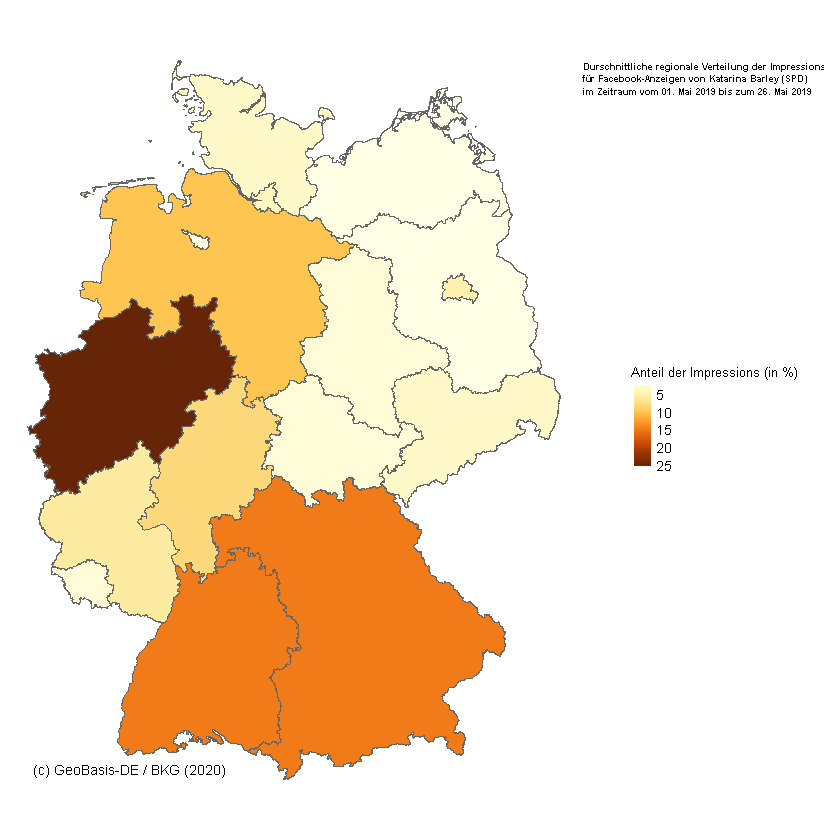

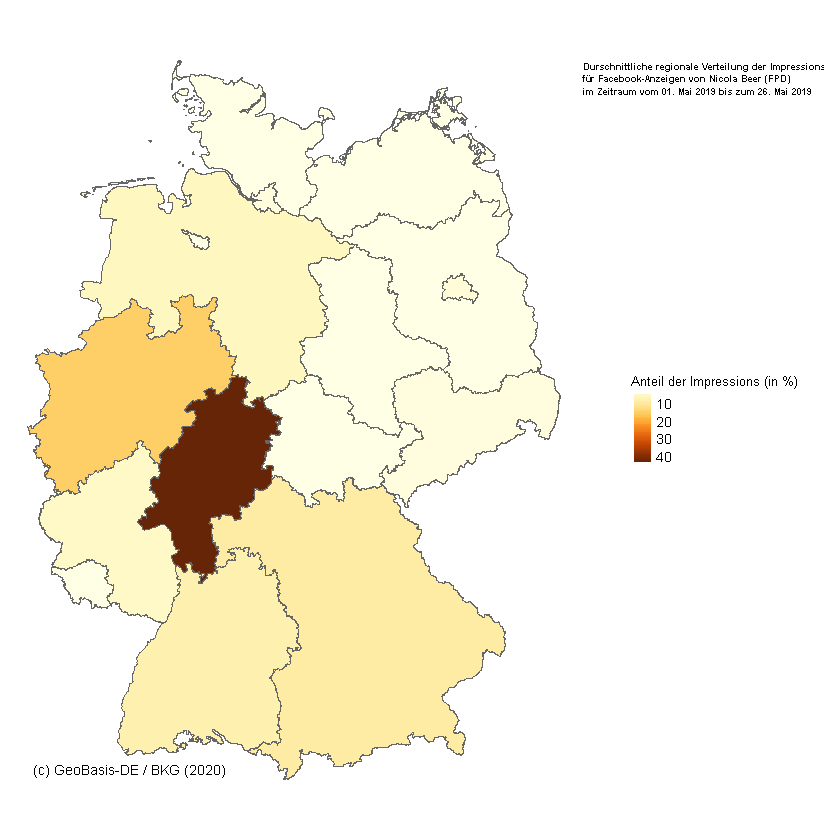

In [19]:
# Karten Daten vom BKG herunterladen und entpacken
download.file("https://daten.gdz.bkg.bund.de/produkte/vg/nuts250_1231/aktuell/nuts250_12-31.utm32s.shape.zip", "./data/nuts250_sf.zip")
unzip("./data/nuts250_sf.zip")

# Einlesen der Deutschlandkarte mit Bundesländergrenzen
nuts_de <-
  read_sf("./data/nuts250_2018-12-31.utm32s.shape/nuts250/250_NUTS1.shp") %>% 
  filter(GF == 4) # ohne Wasser

# Erstellung von Dataframes mit Impressions pro Bundesland für jede Kandidatin
regions_barley <- df_region %>% 
  filter(candidate == "Katarina Barley (SPD)") %>% 
  select(region, ad_mean) %>% 
  mutate(ad_perc = ad_mean*100)

regions_beer <- df_region %>% 
  filter(candidate == "Nicola Beer (FDP)") %>% 
  select(region, ad_mean) %>% 
  mutate(ad_perc = ad_mean*100)

# Karte mit Daten verbinden und Plots erstellen
map_barley <- dplyr::left_join(
    nuts_de, regions_barley,
    by = c("NUTS_NAME" = "region")
  )

tm_shape(map_barley) +
  tm_polygons("ad_perc",
              style = "cont",
              title = "Anteil der Impressions (in %)") +
  tm_layout(title = paste("Durschnittliche regionale Verteilung der Impressions \nfür Facebook-Anzeigen von Katarina Barley (SPD) \nim Zeitraum vom", format(date(date_observation_start), "%d. %b %Y"), "bis zum",
                          format(date(date_observation_end), "%d. %b %Y")),
            title.fontface = "bold",
            legend.outside = T,
            legend.position = c("right", "center"),
            legend.title.size = 0.75,
            frame = F) +
  tm_credits("(c) GeoBasis-DE / BKG (2020)", position=c("left", "bottom"))

map_beer <- dplyr::left_join(
  nuts_de, regions_beer,
  by = c("NUTS_NAME" = "region")
)

tm_shape(map_beer) +
  tm_polygons("ad_perc",
              style = "cont",
              title = "Anteil der Impressions (in %)") +
  tm_layout(title = paste("Durschnittliche regionale Verteilung der Impressions \nfür Facebook-Anzeigen von Nicola Beer (FPD) \nim Zeitraum vom", format(date(date_observation_start), "%d. %b %Y"), "bis zum",
                          format(date(date_observation_end), "%d. %b %Y")),
            title.fontface = "bold",
            legend.outside = T,
            legend.position = c("right", "center"),
            legend.title.size = 0.75,
            frame = F) +
  tm_credits("(c) GeoBasis-DE / BKG (2020)", position=c("left", "bottom"))

Die Plots zeigen, dass der der größte Anteil von Impressions für die Facebook-Anzeigen von Katarina Barley aus Nordrhein-Westfalen kam. Bei Nicola Beer ist Hessen der regionale Schwerpunkt der Impressions.

## Text der Werbeanzeigen

Analog zur Analyse von Tweets kann man auch für die Texte der Facebook-Anzeigen einfache Auswertungen wie die Berechnung von (relativen) Worthäufigkeiten erstellen. Wie immer ist hierfür zuerst Datenaufbereitung nötig.

In [20]:
ad_text <- df_x %>% 
  select(ad_creative_body, candidate, ad_id) %>% 
  unnest_tokens(word, ad_creative_body) %>% # Aufteilung der Texte -> ein Wort pro Reihe im Datensatz
  anti_join(.,
            get_stopwords(language ="de")) %>% # Stopwörter entfernen
  filter(str_detect(word, "[a-z]"), 
         nchar(word) > 2, # nur Wörter mit mindestens 2 Zeichen
  )

Joining, by = "word"



Zunächst einmal kann man sich einfach die häufigsten Wörter in den Facebook-Anzeigen für die beiden Politikerinnen im Vergleich anschauen. NB: Aufgrund des großen Unterschieds in der Anzahl der Facebook-Anzeigen unterscheiden sich auch die absoluten Worthäufigkeiten entsprechend.

Selecting by n



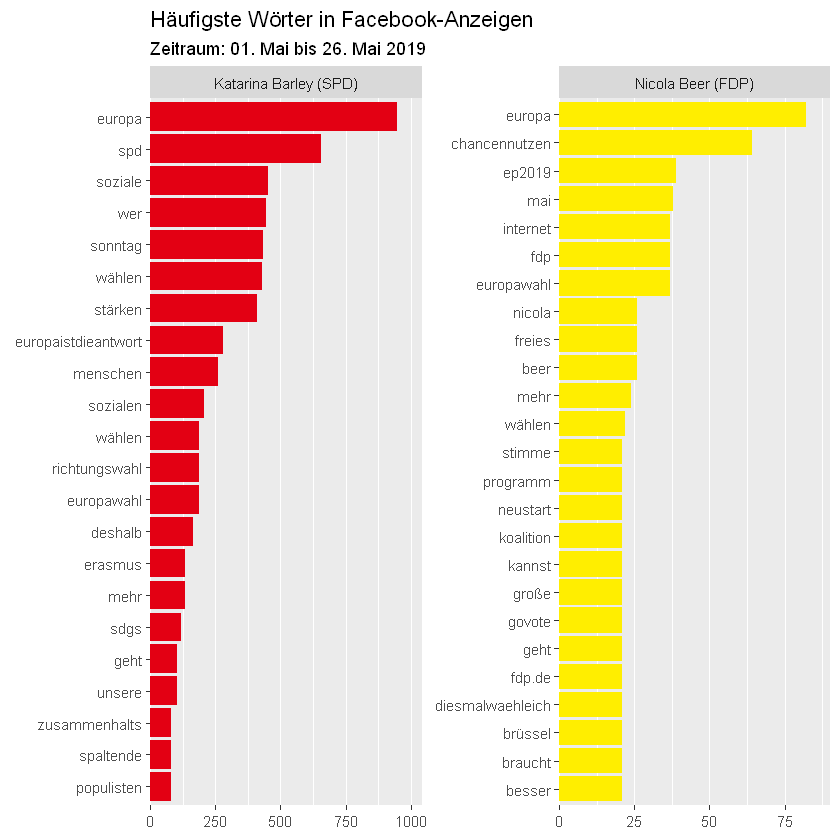

In [21]:
frequency <- ad_text %>% # Worthäufigkeiten pro Kandidatin
  count(candidate, word)

# Plot
frequency %>%
  group_by(candidate) %>%
  top_n(20) %>%
  ungroup() %>%
  ggplot(aes(reorder_within(word, n, candidate), n,
             fill = candidate)) +
  geom_col() +
  scale_x_reordered() +
  coord_flip() +
  facet_wrap(~candidate, scales = "free") +
  scale_y_continuous(expand=expand_scale(mult=c(0, 0.1))) +
  labs(title="Häufigste Wörter in Facebook-Anzeigen", 
       subtitle="Zeitraum: 01. Mai bis 26. Mai 2019",
       x= NULL, 
       y= "Word Count")+
  theme(axis.title = element_blank(),
        panel.grid.major.y = element_blank(),
        legend.position="none") +
  scale_fill_manual(values = colors)

Darüber hinaus kann man bspw. auch die relativen Häufigkeiten von Wörtern vergleichen, die in den Anzeigetexten beider Politikerinnen enthalten sind.

Warning message:
"Removed 418 rows containing missing values (geom_point)."
Warning message:
"Removed 418 rows containing missing values (geom_text)."


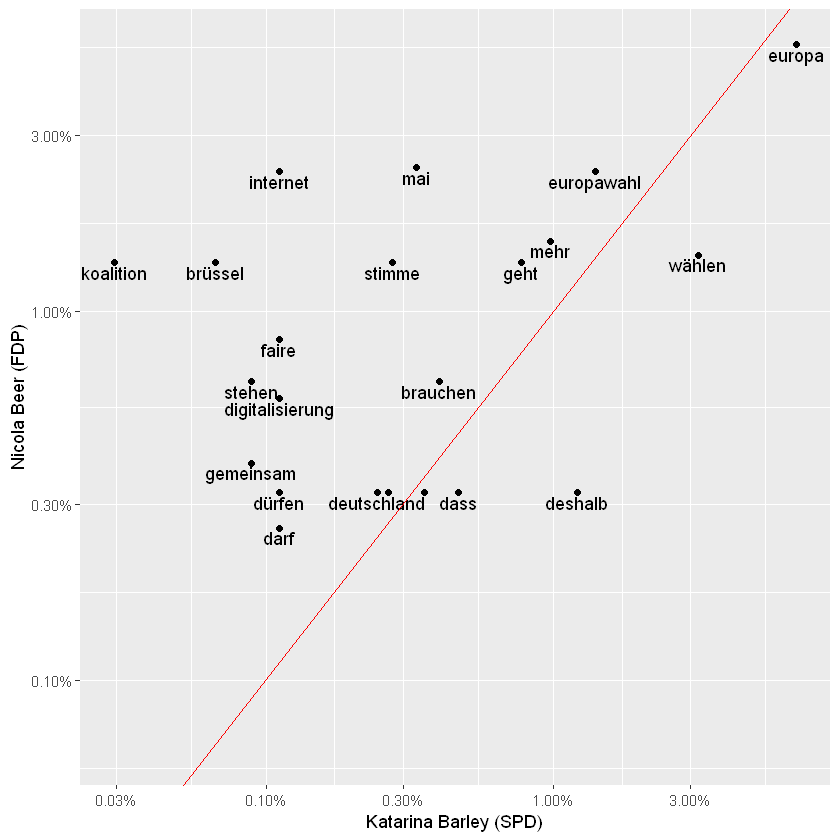

In [22]:
rel_freq <- frequency %>% 
  group_by(candidate) %>% 
  mutate(total = sum(n),
         freq = n/total) %>% 
  ungroup() %>%
  select(candidate, word, freq) %>% 
  spread(candidate, freq) %>% arrange(`Katarina Barley (SPD)`, `Nicola Beer (FDP)`)

rel_freq %>% 
  ggplot(aes(`Katarina Barley (SPD)`, `Nicola Beer (FDP)`)) +
  geom_point() +
  geom_text(aes(label = word), check_overlap = T, vjust = 1.2) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  geom_abline(color = "red")

Aufgrund der sehr unterschiedlichen Anzahl an Werbeanzeigen sowie der geringen Anzahl von Anzeigen von Nicola Beer sind die Vergleiche der Worthäufigkeiten für diese beiden Politikerinnen mit Vorsicht zu interpretieren. Generell ist die Anzahl an unterschiedlichen Wörtern in diesem speziellen Textcorpus problematisch für jede Form von Text-Mining-Analyse.

In [23]:
# Anzahl distinkter Wörter in den Anzeigetexten der beiden Kandidatinnen
ad_text %>% 
  distinct(word) %>% 
  nrow()

# Anzahl an Wörtern, die in den Anzeigen beider Politikerinnen enthalten sind
rel_freq %>% 
  filter(!is.na(`Katarina Barley (SPD)`), !is.na(`Nicola Beer (FDP)`)) %>% 
  nrow()

[1] 443

[1] 25

# Weitere Analysemöglichkeiten

Zusätzlich zu den in diesem Notebook vorgestellten Analysen sind mit den Daten aus der Facebook Ad Library natürlich auch noch weitere Auswertungen möglich. So liefen die Daten z.B. auch Informationen dazu, wer die Werbeanzeigen bezahlt hat.

In [24]:
df_x %>% 
  count(candidate, funding_entity)

candidate,funding_entity,n
<chr>,<chr>,<int>
Katarina Barley (SPD),SPD,1410
Nicola Beer (FDP),FDP,96


Im Fall von Katarina Barley und Nicola Beer sind diese Ergebnisse nicht besonders spannend, da die Facebook-Anzeigen von beiden jeweils ausschließlich von ihren jeweiligen Parteien finanziert wurden.

Für weitere Auswertungsideen lohnt sich ein Blick auf den zu Beginn dieses Notebooks erwähnten [Blog-Post von Roland Schmidt](https://rpubs.com/zoowalk/FB_EP2019). Einige der hier gezeigten Analysen lassen sich auch auf Daten aus dem [Google-Transparenzbericht zu politischer Werbung in Deutschland](https://transparencyreport.google.com/political-ads/region/DE) anwenden. Dieser kann über die Webseite vollständig heruntergeladen werden. Die Datenstruktur (verschiedene .csv-Dateien) wird in einer ReadMe-Datei erklärt. Der Code im vorliegenden Notebook muss zur Auswertung der Daten aus dem Google-Transparenzbericht entsprechend angepasst werden.